#Stock Price Direction Prediction: Will the Closing Price Increase or Decrease Tomorrow?

In this project, we explore the task of predicting the direction of stock price movement — specifically, whether the closing price of a stock will increase or decrease the next day.

Using historical stock market data for HCL Technologies (HCLTECH.NS), we build both machine learning and deep learning models to analyze patterns and trends that could help forecast daily price direction.

The goal is not to predict the exact future stock price, but rather to classify each day as leading to a "price increase" or "price decrease" on the following trading day.

We experiment with various models including Logistic Regression, Random Forest, XGBoost, LSTM, and GRU, and compare their performances using several evaluation metrics.



First, we import all the necessary libraries. These include tools for data fetching, processing, and visualization, followed by modules for time series analysis, machine learning, and deep learning. This setup prepares us to handle everything from data collection to model evaluation in our project.



In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

Next, we fetch historical stock data for HCL Technologies from Yahoo Finance using the yfinance library, specifying the date range from May 2022 to January 2025. We check if the data is successfully retrieved; if not, we alert the user and stop the execution. Once confirmed, we also check for any missing values in the dataset to ensure the data is clean and ready for analysis.



In [3]:
# Download data using yfinance
ticker = 'HCLTECH.NS'
start_date = "2022-05-01"
end_date = "2025-01-16"
df = yf.download(ticker, start=start_date, end=end_date)

if df.empty:
    print("❌ No data fetched! Please check the ticker symbol or date range.")
    exit()

print("✅ Data downloaded successfully!")

# Display number of missing values in each column
missing_values = df.isnull().sum()
print("Missing values per column:\n")
print(missing_values)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

✅ Data downloaded successfully!
Missing values per column:

Price   Ticker    
Close   HCLTECH.NS    0
High    HCLTECH.NS    0
Low     HCLTECH.NS    0
Open    HCLTECH.NS    0
Volume  HCLTECH.NS    0
dtype: int64


After downloading the data, we first flatten the column structure in case the DataFrame has a multi-index format. We then double-check for any missing values again to ensure the dataset is clean. Next, we visualize the stock’s price movement over time by plotting the Open, Close, High, and Low prices. This helps us understand the general price trend and fluctuations over the selected period. We also create a focused plot of the Closing prices to get a clear view of how the stock performed over time, making use of formatted date ticks for better readability.

Missing values per column:

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


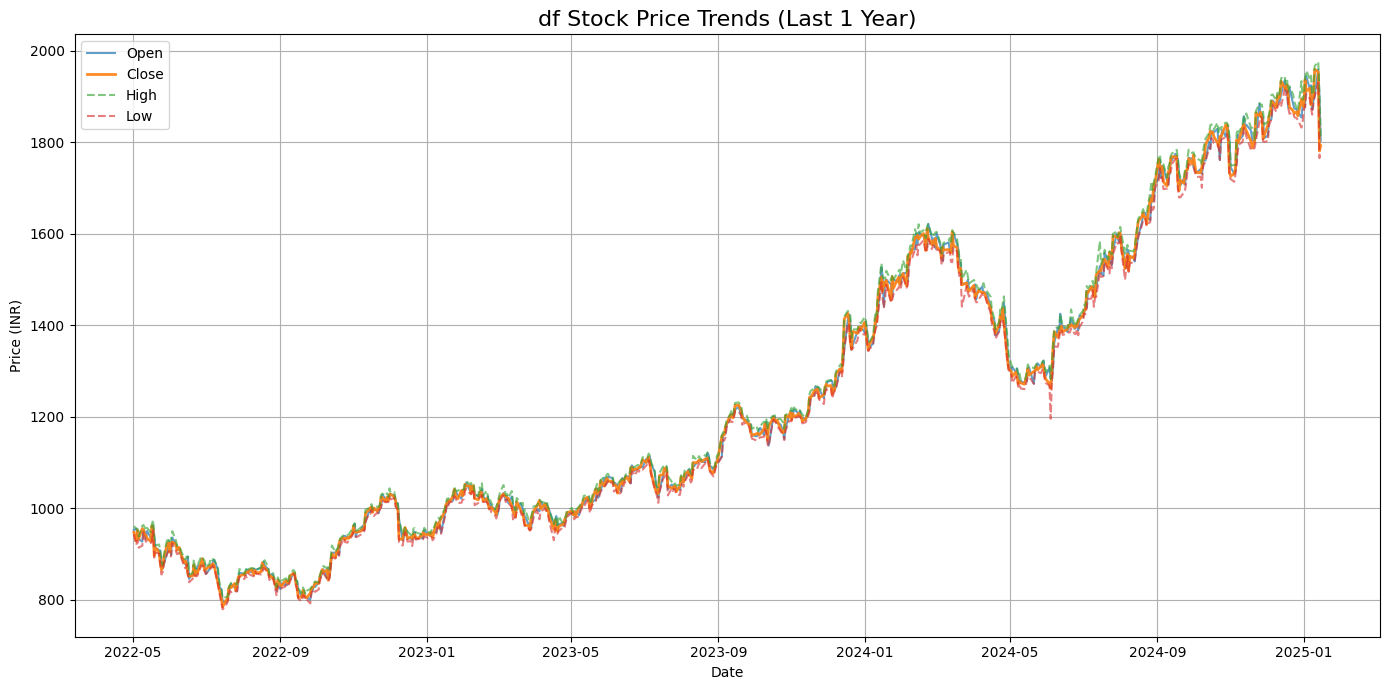

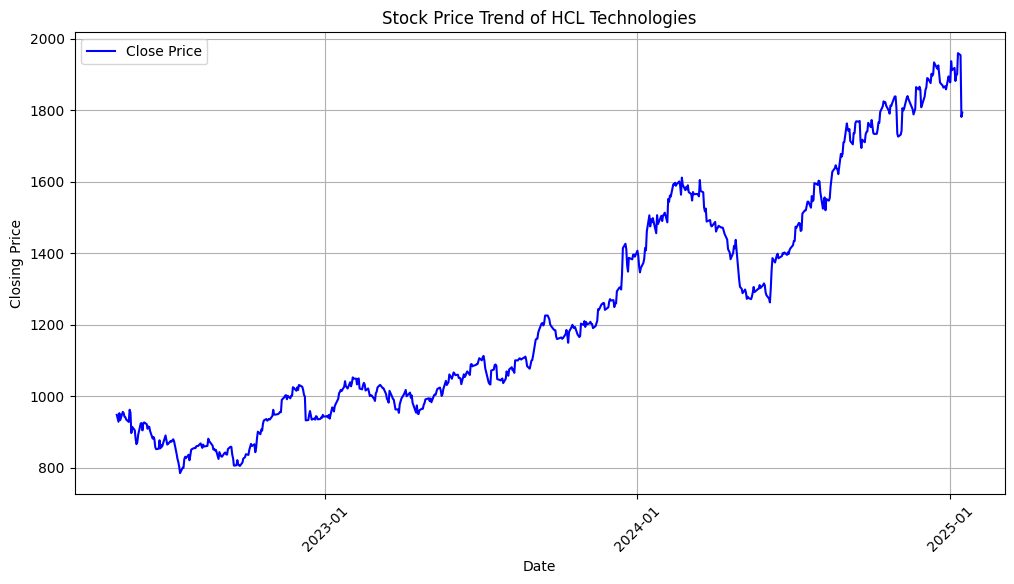

In [4]:
# Flatten the multi-index columns
df.columns = [col[0] for col in df.columns]

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n")
print(missing_values)

import matplotlib.pyplot as plt

# Plotting Open, Close, High, and Low prices
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Open'], label='Open', alpha=0.7)
plt.plot(df.index, df['Close'], label='Close', alpha=0.9, linewidth=2)
plt.plot(df.index, df['High'], label='High', linestyle='--', alpha=0.6)
plt.plot(df.index, df['Low'], label='Low', linestyle='--', alpha=0.6)

plt.title('df Stock Price Trends (Last 1 Year)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot stock closing prices
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Price Trend of HCL Technologies')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


We begin by cleaning the column names to remove any unwanted spaces. Then, we ensure that key financial columns like Open, High, Low, Close, and Volume are properly converted to numeric format for accurate analysis. After that, we identify the days when the stock’s closing price decreased compared to the previous day, which helps us observe negative trends. Finally, we use a boxplot to visually detect outliers in the numeric columns, giving us insight into any unusual price movements or data anomalies.



          Date        Close  Close Decrease
0   2022-05-04   928.120117            True
1   2022-05-06   932.783264            True
2   2022-05-10   952.634521            True
3   2022-05-11   942.286987            True
4   2022-05-12   940.954651            True
..         ...          ...             ...
314 2025-01-01  1877.487915            True
315 2025-01-03  1911.562500            True
316 2025-01-07  1881.366821            True
317 2025-01-13  1953.541992            True
318 2025-01-14  1780.861572            True

[319 rows x 3 columns]


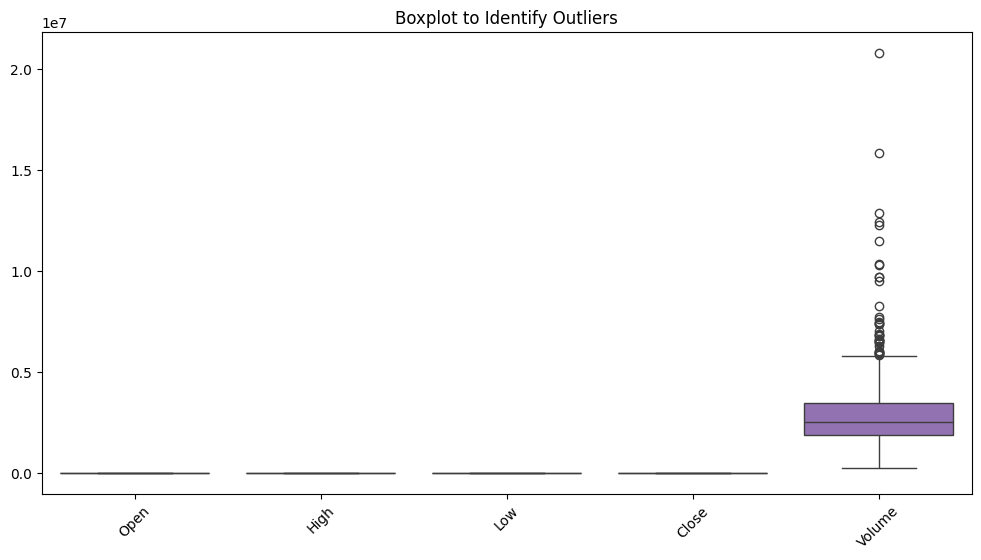

In [5]:
## Now make sure all column names are clean
df.columns = df.columns.str.strip()

# Define numeric columns
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Convert numeric columns to float
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"❌ Column not found: {col}")


df['Close Decrease'] = df['Close'].diff() < 0
decreasing_days = df[df['Close Decrease']].copy()
decreasing_days.reset_index(inplace=True)
print(decreasing_days[['Date', 'Close', 'Close Decrease']])


# Boxplot for outlier detection
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_columns])
plt.xticks(rotation=45)
plt.title("Boxplot to Identify Outliers")
plt.show()



We sort the dataset by date to maintain chronological order, which is essential for time series analysis. After sorting, we reset the index to move the 'Date' from the index back into a regular column, making it easier to reference and manipulate later. Finally, we rename the index column to ‘Date’ to keep the column naming consistent and clear.

In [6]:
df.sort_index(inplace=True)
df.reset_index(inplace=True)  # Moves 'Date' back into a column
df.rename(columns={'index': 'Date'}, inplace=True)

Next, we create the target variable for our classification task. The goal is to predict whether the stock’s closing price will increase the next day. We calculate the difference in closing price and define the target column as 1 if tomorrow’s closing price is higher than today’s, and 0 otherwise. Finally, we drop the last row of the dataset since it cannot have a target value.



In [7]:
# Create target column: 1 if tomorrow's Close > today's, else 0
df['Close Decrease'] = df['Close'].diff().fillna(0)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop last row since it has no target
df.dropna(inplace=True)

Now, we perform some basic feature engineering to enrich our dataset. We convert the 'Date' column to datetime format and extract additional time-based features: day of the week, month, and year. These new features can help our models capture potential patterns or seasonality in stock price movements related to specific days or months.

In [8]:
# Feature engineering
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

Now, we prepare our data for modeling. We select a set of relevant features—such as stock prices (Open, High, Low, Close), trading volume, and the time-based features (Day of the Week, Month, Year)—to use as inputs (X) for our model. The target variable (y) is the column we created earlier, indicating whether the stock’s closing price will increase the following day.



In [9]:
# Select features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'DayOfWeek', 'Month', 'Year']
X = df[features]
y = df['Target']

Next, we split the dataset into training and testing sets. We use 80% of the data for training the model and reserve 20% for testing its performance. Since this is time series data, we set shuffle=False to maintain the chronological order—this ensures that future data isn’t used to predict the past, which would lead to data leakage.

In [10]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

We begin by training a Logistic Regression model using our training data. Logistic Regression is a simple yet effective baseline model for binary classification tasks like predicting stock price direction. After training, we use the model to make predictions on the test set. We then evaluate its performance by calculating the accuracy, displaying the confusion matrix, and generating a detailed classification report. To better interpret the model’s results, we also visualize the confusion matrix using a heatmap.



Accuracy: 0.5074626865671642

Confusion Matrix:
[[36 29]
 [37 32]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.55      0.52        65
           1       0.52      0.46      0.49        69

    accuracy                           0.51       134
   macro avg       0.51      0.51      0.51       134
weighted avg       0.51      0.51      0.51       134



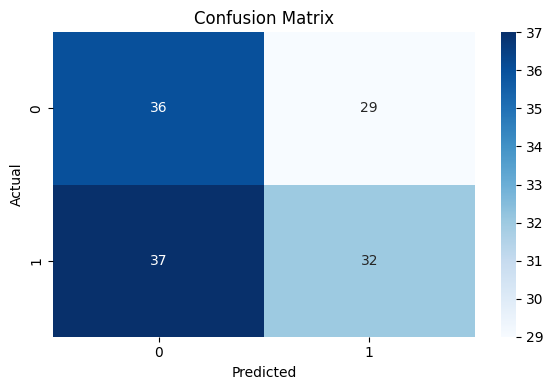

In [11]:
# Train logistic regression model
lg_model = LogisticRegression(max_iter=1000)
lg_model.fit(X_train, y_train)

# Make predictions
y_pred = lg_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualise confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

The Logistic Regression model achieved an accuracy of approximately 50.7%, which is only slightly better than random guessing for this binary classification task. The confusion matrix shows a relatively balanced number of correct and incorrect predictions for both classes. The precision, recall, and F1-scores are also around 50%, indicating that the model struggles to consistently distinguish between days when the stock price will increase or decrease. This suggests that predicting short-term stock movements is inherently challenging, and more advanced models or additional features may be needed for better performance.




We now train a Random Forest Classifier, a more advanced ensemble method that combines multiple decision trees to improve prediction accuracy and reduce overfitting. After training the model on our training data, we make predictions on the test set. We then evaluate its performance by calculating the accuracy, generating a confusion matrix, and producing a detailed classification report. Finally, we visualize the confusion matrix to easily compare how well the model distinguishes between days when the stock price increases or decreases



Accuracy: 0.5

Confusion Matrix:
[[60  5]
 [62  7]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.92      0.64        65
           1       0.58      0.10      0.17        69

    accuracy                           0.50       134
   macro avg       0.54      0.51      0.41       134
weighted avg       0.54      0.50      0.40       134



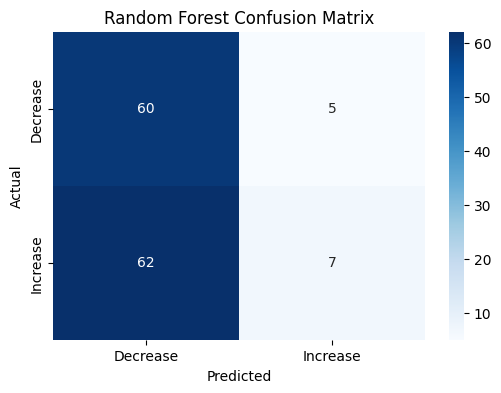

In [16]:
# Train the model
rf_model = RandomForestClassifier(random_state=42)
# Use the original X_train and y_train which are 2D
rf_model.fit(X_train, y_train)

# Predict
# Use the original X_test for prediction
rf_predictions = rf_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_predictions)

# Visualisation
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Decrease", "Increase"], yticklabels=["Decrease", "Increase"])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The Random Forest model achieved an overall accuracy of 50%, which is similar to the Logistic Regression model. However, looking deeper into the results, we see that the model is biased toward predicting days with a price decrease (class 0), achieving a high recall for this class but very low recall for days when the price increases (class 1). This imbalance is reflected in the precision, recall, and F1-scores. These results highlight that while Random Forest is a powerful model, stock price direction remains a challenging and noisy prediction task, especially without incorporating more sophisticated features or external signals.


Next, we train an XGBoost Classifier, a highly optimized gradient boosting algorithm known for its performance in structured data problems. After training the model, we use it to predict stock price movements on the test set. We then evaluate its performance using accuracy, a confusion matrix, and a detailed classification report. To better interpret the results, we visualize the confusion matrix, which allows us to see how well the model differentiates between price increases and decreases. XGBoost often outperforms simpler models, so this step helps us assess whether it provides an edge in this stock prediction task.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:18:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5373134328358209

Confusion Matrix:
[[51 14]
 [48 21]]
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.78      0.62        65
           1       0.60      0.30      0.40        69

    accuracy                           0.54       134
   macro avg       0.56      0.54      0.51       134
weighted avg       0.56      0.54      0.51       134



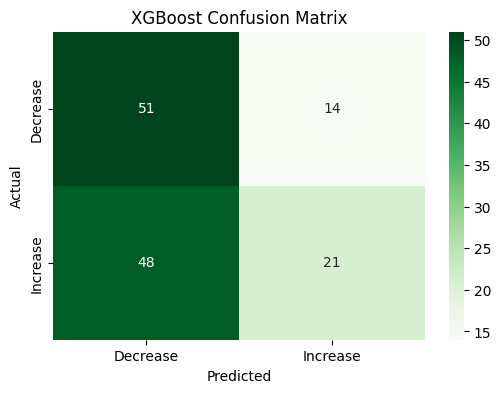

In [18]:
# Train the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
xgb_predictions = xgb_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, xgb_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, xgb_predictions))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

# Confusion Matrix
xgb_cm = confusion_matrix(y_test, xgb_predictions)

# Visualisation
plt.figure(figsize=(6, 4))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Greens', xticklabels=["Decrease", "Increase"], yticklabels=["Decrease", "Increase"])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The XGBoost model achieved an accuracy of approximately 53.7%, showing a slight improvement over both the Logistic Regression and Random Forest models. The confusion matrix and classification report indicate that the model is better at predicting price decreases (class 0), with a higher recall and F1-score for this class. Its performance on predicting price increases (class 1) is still relatively modest, reflecting the inherent difficulty in forecasting short-term stock movements. Nonetheless, XGBoost demonstrates its capability to extract more nuanced patterns from the data compared to simpler models.



Next, we experiment with a Long Short-Term Memory (LSTM) network — a type of recurrent neural network well-suited for capturing sequential dependencies in time-series data, such as stock prices. We first perform feature scaling using MinMaxScaler to ensure all input features are normalized. Next, we create sequences of past 10 days' data to provide temporal context for the model.

We design a simple LSTM model with 50 units followed by a dense output layer with a sigmoid activation to perform binary classification. After compiling the model with the Adam optimizer and binary cross-entropy loss, we train it for 10 epochs while monitoring both training and validation accuracy and loss.

Once trained, we generate predictions and evaluate the LSTM model using accuracy, a confusion matrix, and a classification report. We also visualize training/validation accuracy and loss over epochs to observe the model’s learning behavior. Finally, we display a heatmap of the confusion matrix to assess how well the LSTM model distinguishes between increasing and decreasing stock prices.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5511 - loss: 0.6912 - val_accuracy: 0.4848 - val_loss: 0.7066
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4902 - loss: 0.6944 - val_accuracy: 0.5152 - val_loss: 0.6925
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5452 - loss: 0.6906 - val_accuracy: 0.4924 - val_loss: 0.6940
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5436 - loss: 0.6923 - val_accuracy: 0.4621 - val_loss: 0.6947
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4987 - loss: 0.6936 - val_accuracy: 0.4848 - val_loss: 0.6973
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5217 - loss: 0.6928 - val_accuracy: 0.4848 - val_loss: 0.6990
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5120 - loss: 0.6931 - val_accuracy: 0.4848 - val_loss: 0.6949
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5263 - loss: 0.6935 - val_accuracy: 0.4848 - val_loss

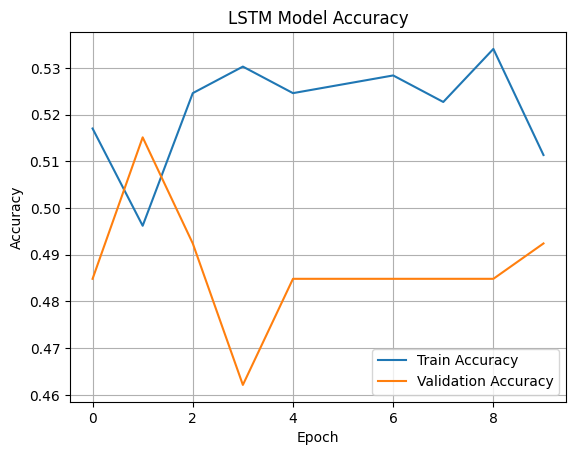

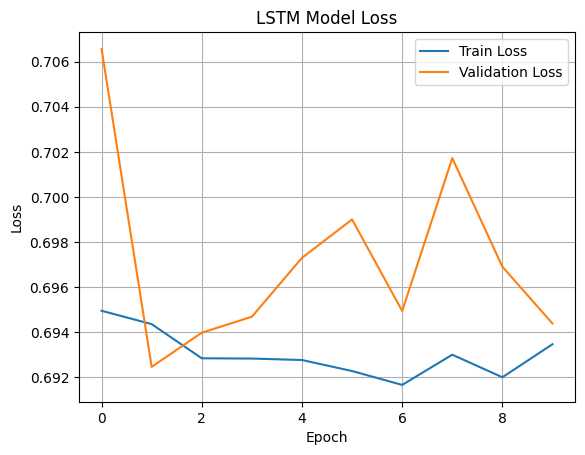

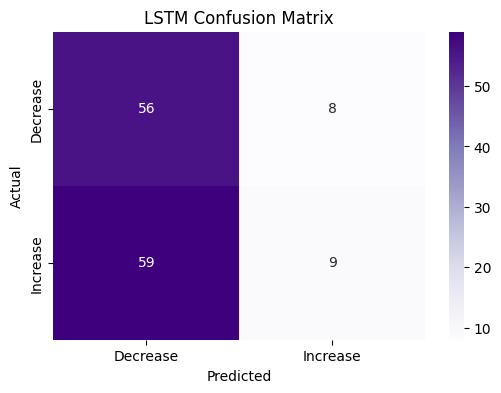

In [19]:
features = ['Close', 'High', 'Low', 'Open', 'Volume']
target = 'Target'

# Scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])

# Add the target column
scaled_df = pd.DataFrame(scaled_features, columns=features)
scaled_df['Target'] = df['Target'].values

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data.iloc[i - seq_length:i][features].values)
        y.append(data.iloc[i][target])
    return np.array(X), np.array(y)

# Set sequence length (e.g., 10 days)
sequence_length = 10
X, y = create_sequences(scaled_df, sequence_length)

# Use 80% data for training
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

# Predict and convert to binary
y_pred_prob = lstm_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred))

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualise
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=["Decrease", "Increase"], yticklabels=["Decrease", "Increase"])
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

After training the LSTM model, we evaluate its performance on the test set. The overall accuracy is approximately 49%, which indicates that the model is struggling to consistently classify stock price movements in this case. The confusion matrix reveals that the model performs much better at identifying days where the stock decreases, but it has difficulty correctly predicting days of increase. The precision, recall, and F1-scores in the classification report further confirm this imbalance in prediction.

This outcome suggests that while the LSTM has captured some sequential patterns, further tuning of hyperparameters, model architecture, or additional features may be needed to improve its predictive power for stock price direction.



We next built and trained a GRU (Gated Recurrent Unit) model to capture temporal patterns in stock prices. The GRU model was trained for 20 epochs using scaled sequential data. After training, we evaluated its performance on the test set.

The accuracy and loss curves help us observe the model's learning progress. Finally, we assessed its predictive performance using the confusion matrix, accuracy, and classification report. This provides further insights into how well the GRU model is able to classify stock price movement directions compared to previous models.



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5372 - loss: 0.6950 - val_accuracy: 0.5152 - val_loss: 0.6931
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5317 - loss: 0.6928 - val_accuracy: 0.5152 - val_loss: 0.6948
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5039 - loss: 0.6932 - val_accuracy: 0.4848 - val_loss: 0.6946
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5003 - loss: 0.6927 - val_accuracy: 0.4848 - val_loss: 0.6931
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5311 - loss: 0.6915 - val_accuracy: 0.5152 - val_loss: 0.6928
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5051 - loss: 0.6930 - val_accuracy: 0.4697 - val_loss: 0.6943
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5325 - loss: 0.6902 - val_accuracy: 0.4924 - val_loss: 0.6937
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5295 - loss: 0.6909 - val_accuracy: 0.4697 - val_loss: 0.

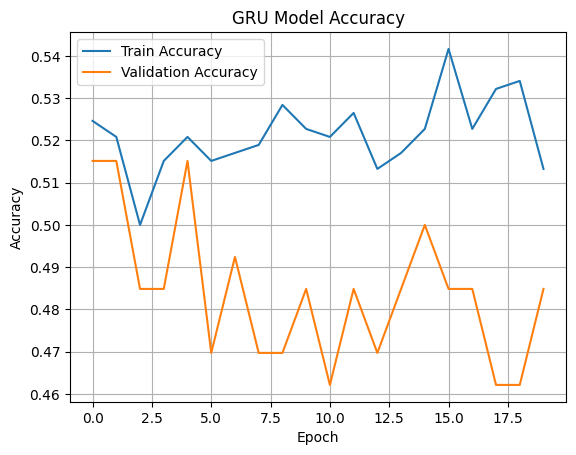

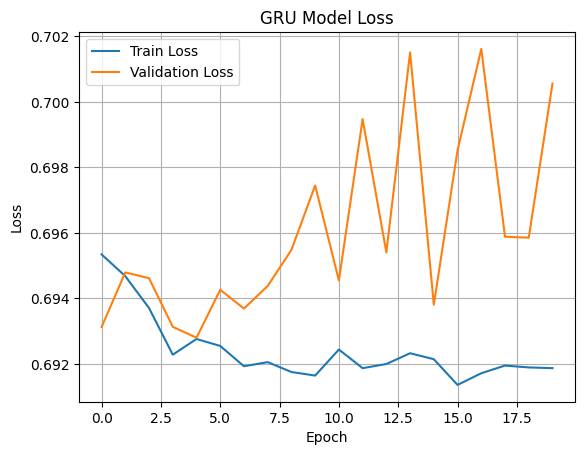

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


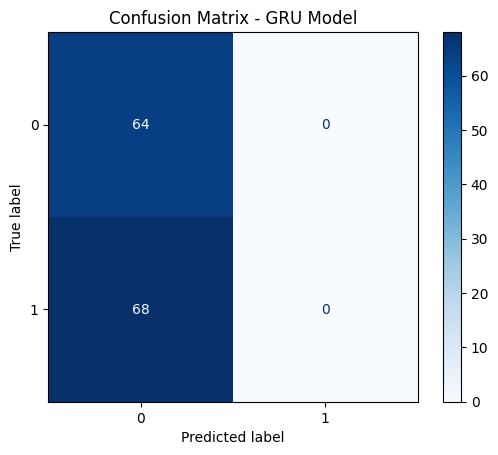

Accuracy: 0.48484848484848486

Confusion Matrix:
[[64  0]
 [68  0]]
              precision    recall  f1-score   support

         0.0       0.48      1.00      0.65        64
         1.0       0.00      0.00      0.00        68

    accuracy                           0.48       132
   macro avg       0.24      0.50      0.33       132
weighted avg       0.24      0.48      0.32       132



In [20]:
# Build GRU model
gru_model = Sequential()
gru_model.add(GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dense(1, activation='sigmoid'))

# Compile model
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train model
history = gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Predict probabilities
y_pred_prob = gru_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - GRU Model")
plt.show()


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
# Classification report
print(classification_report(y_test, y_pred))

The GRU model achieved an accuracy of approximately 48.5%, but the confusion matrix reveals it only predicted the "Decrease" class (0) and failed to correctly identify any "Increase" cases (1). This is reflected in the classification report where the model shows perfect recall for class 0 but zero recall and precision for class 1, indicating the model is heavily biased towards predicting decreases. Overall, this suggests the model struggles to effectively distinguish upward price movements in the given data.


#ROC Curve Comparison of Different Models

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


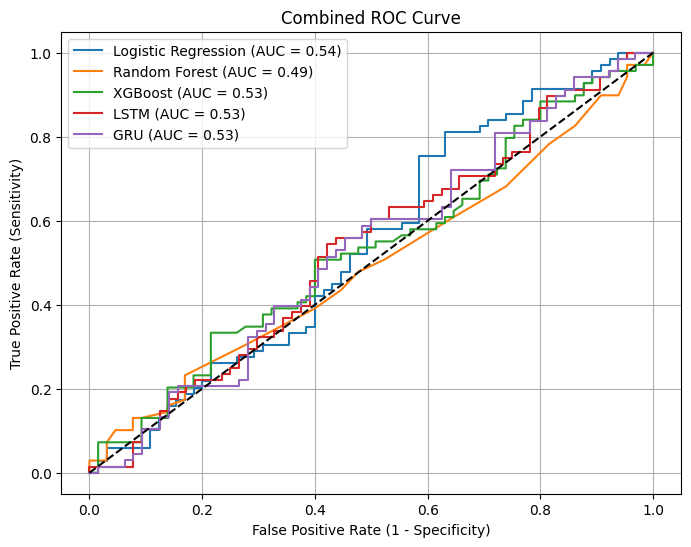

In [21]:
plt.figure(figsize=(8, 6))

# Store the X_test used for non-sequence models before it's overwritten
# The original split was done earlier in the notebook using df[features]
# Re-split the data using the original features to get the correct X_test
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'DayOfWeek', 'Month', 'Year']
X = df[features]
y = df['Target']
X_train_classic, X_test_classic, y_train_classic, y_test_classic = train_test_split(X, y, test_size=0.2, shuffle=False)


# Logistic Regression
fpr, tpr, _ = roc_curve(y_test_classic, lg_model.predict_proba(X_test_classic)[:, 1])
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc(fpr, tpr):.2f})')

# Random Forest
fpr, tpr, _ = roc_curve(y_test_classic, rf_model.predict_proba(X_test_classic)[:, 1])
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc(fpr, tpr):.2f})')

# XGBoost
fpr, tpr, _ = roc_curve(y_test_classic, xgb_model.predict_proba(X_test_classic)[:, 1])
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc(fpr, tpr):.2f})')

# LSTM
y_pred_lstm = lstm_model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm)
plt.plot(fpr, tpr, label=f'LSTM (AUC = {auc(fpr, tpr):.2f})')

# GRU
y_pred_gru = gru_model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_gru)
plt.plot(fpr, tpr, label=f'GRU (AUC = {auc(fpr, tpr):.2f})')

# Random line
plt.plot([0, 1], [0, 1], 'k--')

plt.title('Combined ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.legend()
plt.grid(True)
plt.show()


#Precision-Recall Curve Comparison of Different Models

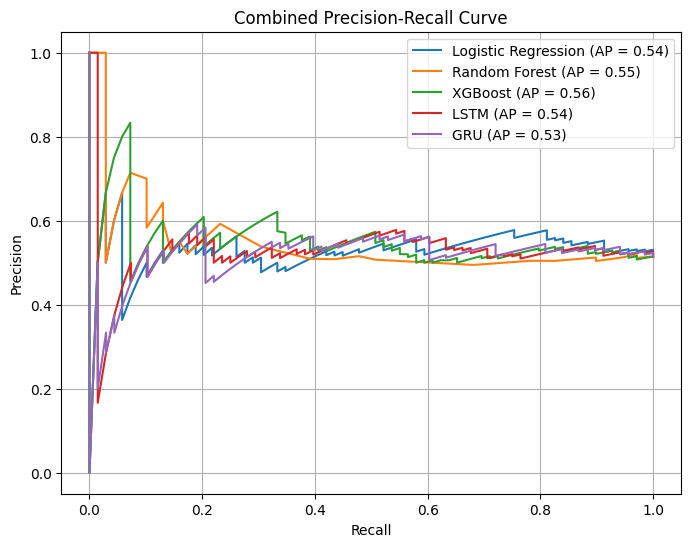

In [22]:
plt.figure(figsize=(8, 6))

# Logistic Regression
precision, recall, _ = precision_recall_curve(y_test_classic, lg_model.predict_proba(X_test_classic)[:, 1])
plt.plot(recall, precision, label=f'Logistic Regression (AP = {average_precision_score(y_test_classic, lg_model.predict_proba(X_test_classic)[:, 1]):.2f})')

# Random Forest
precision, recall, _ = precision_recall_curve(y_test_classic, rf_model.predict_proba(X_test_classic)[:, 1])
plt.plot(recall, precision, label=f'Random Forest (AP = {average_precision_score(y_test_classic, rf_model.predict_proba(X_test_classic)[:, 1]):.2f})')

# XGBoost
precision, recall, _ = precision_recall_curve(y_test_classic, xgb_model.predict_proba(X_test_classic)[:, 1])
plt.plot(recall, precision, label=f'XGBoost (AP = {average_precision_score(y_test_classic, xgb_model.predict_proba(X_test_classic)[:, 1]):.2f})')

# LSTM
precision, recall, _ = precision_recall_curve(y_test, y_pred_lstm)
plt.plot(recall, precision, label=f'LSTM (AP = {average_precision_score(y_test, y_pred_lstm):.2f})')

# GRU
precision, recall, _ = precision_recall_curve(y_test, y_pred_gru)
plt.plot(recall, precision, label=f'GRU (AP = {average_precision_score(y_test, y_pred_gru):.2f})')

plt.title('Combined Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


##Conclusion
In this project, we successfully implemented and evaluated multiple models to predict whether the stock's closing price will increase or decrease on the next trading day.

Our results show that while traditional machine learning models provided a baseline level of performance, deep learning models like LSTM and GRU showed potential but would benefit from further tuning and more sophisticated feature engineering to improve their predictive power.

Overall, this project provided valuable hands-on experience with time series classification, feature engineering, and model evaluation in the context of financial data — a challenging and dynamic domain.